# Enabling GPU acceleration
1. Click on Runtime > Change Runtime Type > T4 GPU.
1. On the top-right hand corner, you should see a connect button, click it.

# Installing Dependencies and Downloading Unlearned Weights

In [1]:
!pip install diffusers
import requests
import os
import torch
from diffusers import UNet2DConditionModel
from diffusers.pipelines import StableDiffusionPipeline


weights_url = "https://erasing.baulab.info/weights/esd_models/art/diffusers-VanGogh-ESDx1-UNET.pt"
filename = "diffusers-VanGogh-ESDx1-UNET.pt"
response = requests.get(weights_url, stream=True)

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded '{filename}' successfully!")

Downloaded 'diffusers-VanGogh-ESDx1-UNET.pt' successfully!


In [2]:
from diffusers.utils import make_image_grid

prompt = "Starry Night by Van Gogh"
seed = 42
num_samples = 4
rows = 2
cols = 2

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",                    # Pretrained weights path from huggingface hub
    torch_dtype=torch.float16,
    variant="fp16",
    safety_checker=None                                 # We don't want black images on incorrect NSFW classification
)

device = "cuda" if torch.cuda.is_available else "cpu"   # Declaring the device we want to perform inference on
pipe = pipe.to(device)                                  # Setting hardware acceleration

fully_trained_images = pipe(
    prompt,
    guidance_scale=7.5,                                 # Classifier free guidance
    eta=1.0,                                            # Non deterministic scheduling via DDIM
    generator=torch.manual_seed(seed),
    num_images_per_prompt=num_samples
).images

pipe.unet.load_state_dict(torch.load("diffusers-VanGogh-ESDx1-UNET.pt")) # Load our custom unlearned weights only.
unlearned_images = pipe(
    prompt,
    guidance_scale=7.5,
    eta=1.0,
    num_images_per_prompt=num_samples,
    generator=torch.manual_seed(seed)
).images

grid1 = make_image_grid(fully_trained_images, rows, cols) # Turn list of images into a nice grid for visualization
grid2 = make_image_grid(unlearned_images, rows, cols)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

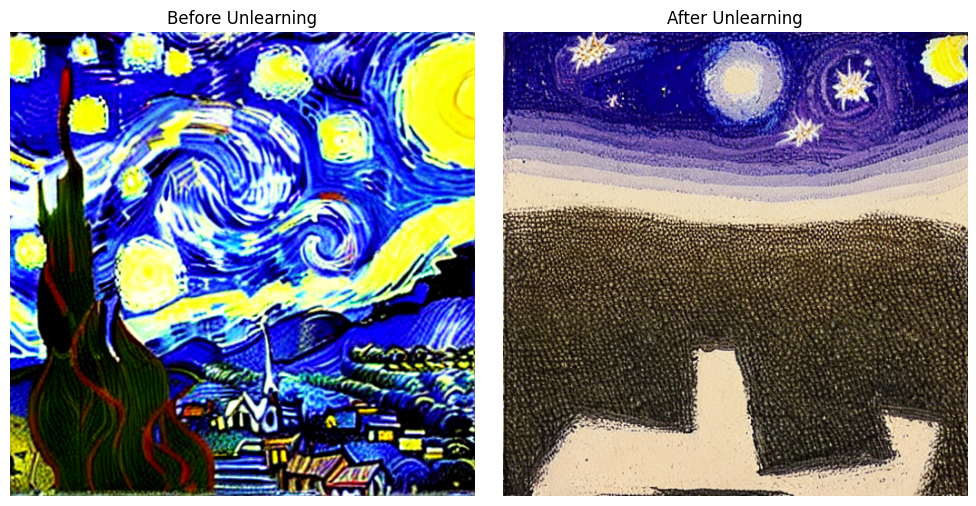

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
axes[0].imshow(grid1)
axes[0].axis('off')
axes[0].set_title('Before Unlearning')

axes[1].imshow(grid2)
axes[1].axis('off')
axes[1].set_title('After Unlearning')

plt.tight_layout()
plt.show()